In [2]:
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
from pylipid.api import LipidInteraction

# Function for natural sorting
def natural_sort_key(filename):
    return [int(text) if text.isdigit() else text for text in re.split(r'(\d+)', filename)]

# Get all DCD files in sorted order
trajfile_list = sorted(glob.glob("step7.*_production.dcd"), key=natural_sort_key)
topfile_list = "step5_input.psf"

trajfile_list


c:\Users\lyj12\anaconda3\envs\MD\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['step7.1_production.dcd',
 'step7.2_production.dcd',
 'step7.3_production.dcd',
 'step7.4_production.dcd',
 'step7.5_production.dcd',
 'step7.6_production.dcd',
 'step7.7_production.dcd',
 'step7.8_production.dcd',
 'step7.9_production.dcd',
 'step7.10_production.dcd',
 'step7.11_production.dcd',
 'step7.12_production.dcd',
 'step7.13_production.dcd',
 'step7.14_production.dcd',
 'step7.15_production.dcd',
 'step7.16_production.dcd',
 'step7.17_production.dcd',
 'step7.18_production.dcd',
 'step7.19_production.dcd',
 'step7.20_production.dcd',
 'step7.21_production.dcd',
 'step7.22_production.dcd',
 'step7.23_production.dcd',
 'step7.24_production.dcd',
 'step7.25_production.dcd']

In [2]:
from itertools import product
import mdtraj as md
from pylipid.util import get_traj_info, check_dir

def plot_minimum_distances(distances, times, title, fn):
    fig, ax = plt.subplots(1, 1, figsize=(3, 2.5))
    ax.plot(times, distances)
    ax.set_xlabel(r"Time ($\mu$s)")
    ax.set_ylabel("Minimum distances (nm)")
    ax.set_title(title)
    ax.set_ylim(0, 1.0)
    plt.tight_layout()
    plt.savefig(fn, dpi=200)
    plt.close()
    return


def compute_minimum_distance(traj, lipid, fig_dir, lipid_atoms=None,
                            contact_frames=10, distance_threshold=0.65):
    DIST_CONTACT_ALL = []
    traj_info, _, _ = get_traj_info(traj, lipid, lipid_atoms=lipid_atoms)
    for protein_idx in np.arange(nprot, dtype=int):
        for residue_idx, residue_atom_indices in enumerate(
            traj_info["protein_residue_atomid_list"][protein_idx]):
            dist_matrix = np.array([np.min(
                            md.compute_distances(traj, np.array(list(product(residue_atom_indices, lipid_atom_indices)))),
                            axis=1) for lipid_atom_indices in traj_info["lipid_residue_atomid_list"]])
            # plot distances
            for lipid_idx in np.arange(len(dist_matrix)):
                if sum(dist_matrix[lipid_idx] < distance_threshold) >= contact_frames:
                    DIST_CONTACT_ALL.append(dist_matrix[lipid_idx])
                    plot_minimum_distances(dist_matrix[lipid_idx], traj.time/1000000.0,
                                           "{}-{}{}".format(traj_info["residue_list"][residue_idx], lipid, lipid_idx),
                                           "{}/dist_{}_{}{}.png".format(fig_dir, traj_info["residue_list"][residue_idx],
                                                                        lipid, lipid_idx))

    return DIST_CONTACT_ALL


trajfile = trajfile_list
topfile = topfile_list
lipid = "POPC"
lipid_atoms = None # all lipid atom/bead will be considered
nprot = 1
save_dir = "test_minimum_dist_A2a_{}".format(lipid)
fig_dir = check_dir(save_dir, "Figures", print_info=False)
contact_frames = 30  # will only plot data if the contact was formed over ${contact_frames} frames.
distance_threshold = 0.65

traj = md.load(trajfile, top=topfile, stride=10)
minimum_distance_set = compute_minimum_distance(traj, lipid, fig_dir, lipid_atoms=lipid_atoms,
                                               contact_frames=10, distance_threshold=0.65)


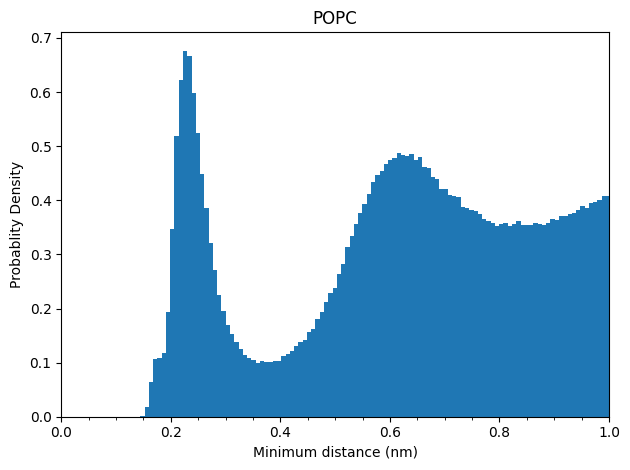

In [3]:
import matplotlib.ticker as ticker

def plot_PDF(distance_set, num_of_bins, fn):
    fig, ax = plt.subplots(1,1)
    ax.hist(distance_set, bins=num_of_bins, density=True)
    ax.set_xlim(0, 1.0)
    ax.set_xlabel("Minimum distance (nm)")
    ax.set_ylabel("Probablity Density")
    ax.set_title(lipid)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.05))
    plt.tight_layout()
    plt.savefig(fn, dpi=200)
    return

distance_set = np.concatenate(minimum_distance_set)
num_of_bins = 1000
fig_fn = "{}/dist_distribut_{}.png".format(save_dir, lipid)
plot_PDF(distance_set, num_of_bins, fig_fn)

In [3]:
import pickle
from itertools import product
import shutil
from pylipid.api import LipidInteraction

# Function to test cutoff values
def test_cutoffs(cutoff_list, trajfile_list, topfile_list, lipid, nprot=2, stride=1, save_dir=None, timeunit="ns"):
    num_of_binding_sites = {}
    duration_avgs = {}
    num_of_contacting_residues = {}
    
    for cutoffs in cutoff_list:
        print(f"Testing cutoff values: {cutoffs}")
        li = LipidInteraction(
            trajfile_list=trajfile_list,
            topfile_list=topfile_list,
            cutoffs=cutoffs,
            lipid=lipid,
            nprot=nprot,
            timeunit=timeunit,
            save_dir=save_dir,
            stride=stride
        )
        
        # Collect interactions and compute properties
        li.collect_residue_contacts()
        li.compute_residue_duration()
        li.compute_binding_nodes(print_data=False)
        
        # Store results for the given cutoffs
        num_of_binding_sites[cutoffs] = len(li.node_list)
        duration_avgs[cutoffs] = li.dataset["Duration"].mean()
        num_of_contacting_residues[cutoffs] = sum(li.dataset["Duration"] > 0)
        
        # Cleanup the save directory for this interaction
        shutil.rmtree(li.save_dir)
    
    return num_of_binding_sites, duration_avgs, num_of_contacting_residues


# Define cutoff ranges
lower_cutoff = [0.2, 0.225, 0.25, 0.275]
upper_cutoff = [0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
cutoff_list = list(product(lower_cutoff, upper_cutoff))

# Define lipid and simulation parameters
stride = 1  # Speed up if too many frames
lipid = "POPC"
nprot = 2  
timeunit = "ns"

# Define your trajectories and topology files
trajfile_list = ["step7.24_production.dcd"]
topfile_list = "step5_input.psf"

# Output directory
save_dir = "./test_cutoffs"

# Run the cutoff tests
num_of_binding_sites, duration_avgs, num_of_contacting_residues = test_cutoffs(
    cutoff_list, trajfile_list, topfile_list, lipid, nprot=nprot, stride=stride, save_dir=save_dir, timeunit=timeunit
)

# Save results to a pickle file
test_data = {
    "num_of_binding_sites": num_of_binding_sites,
    "duration_avgs": duration_avgs,
    "num_of_contacting_residues": num_of_contacting_residues,
    "test_cutoff_list": cutoff_list
}

with open(f"{save_dir}/test_cutoff_data_{lipid}3.pickle", "wb") as f:
    pickle.dump(test_data, f)

print("Cutoff testing completed and results saved.")




Testing cutoff values: (0.2, 0.35)


CALCULATE DURATION PER RESIDUE: 100%|██████████| 43/43 [00:00<00:00, 201.22it/s]


Testing cutoff values: (0.2, 0.4)
Creating new director: c:\Users\lyj12\Desktop\research_Luo\WT_FGFR3tm_homodimer\namd\test_cutoffs\Interaction_POPC


CALCULATE DURATION PER RESIDUE: 100%|██████████| 43/43 [00:00<00:00, 74.33it/s] 


Testing cutoff values: (0.2, 0.45)
Creating new director: c:\Users\lyj12\Desktop\research_Luo\WT_FGFR3tm_homodimer\namd\test_cutoffs\Interaction_POPC


CALCULATE DURATION PER RESIDUE: 100%|██████████| 43/43 [00:00<00:00, 163.47it/s]


Testing cutoff values: (0.2, 0.5)
Creating new director: c:\Users\lyj12\Desktop\research_Luo\WT_FGFR3tm_homodimer\namd\test_cutoffs\Interaction_POPC


CALCULATE DURATION PER RESIDUE: 100%|██████████| 43/43 [00:00<00:00, 134.95it/s]


Testing cutoff values: (0.2, 0.55)
Creating new director: c:\Users\lyj12\Desktop\research_Luo\WT_FGFR3tm_homodimer\namd\test_cutoffs\Interaction_POPC


CALCULATE DURATION PER RESIDUE: 100%|██████████| 43/43 [00:00<00:00, 114.11it/s]


Testing cutoff values: (0.2, 0.6)
Creating new director: c:\Users\lyj12\Desktop\research_Luo\WT_FGFR3tm_homodimer\namd\test_cutoffs\Interaction_POPC


CALCULATE DURATION PER RESIDUE: 100%|██████████| 43/43 [00:00<00:00, 137.63it/s]


Testing cutoff values: (0.225, 0.35)
Creating new director: c:\Users\lyj12\Desktop\research_Luo\WT_FGFR3tm_homodimer\namd\test_cutoffs\Interaction_POPC


CALCULATE DURATION PER RESIDUE: 100%|██████████| 43/43 [00:00<00:00, 121.06it/s]


Testing cutoff values: (0.225, 0.4)
Creating new director: c:\Users\lyj12\Desktop\research_Luo\WT_FGFR3tm_homodimer\namd\test_cutoffs\Interaction_POPC


CALCULATE DURATION PER RESIDUE: 100%|██████████| 43/43 [00:00<00:00, 116.35it/s]


Testing cutoff values: (0.225, 0.45)
Creating new director: c:\Users\lyj12\Desktop\research_Luo\WT_FGFR3tm_homodimer\namd\test_cutoffs\Interaction_POPC


CALCULATE DURATION PER RESIDUE: 100%|██████████| 43/43 [00:00<00:00, 54.22it/s] 


Testing cutoff values: (0.225, 0.5)
Creating new director: c:\Users\lyj12\Desktop\research_Luo\WT_FGFR3tm_homodimer\namd\test_cutoffs\Interaction_POPC


CALCULATE DURATION PER RESIDUE: 100%|██████████| 43/43 [00:00<00:00, 86.13it/s] 


Testing cutoff values: (0.225, 0.55)
Creating new director: c:\Users\lyj12\Desktop\research_Luo\WT_FGFR3tm_homodimer\namd\test_cutoffs\Interaction_POPC


CALCULATE DURATION PER RESIDUE: 100%|██████████| 43/43 [00:00<00:00, 97.52it/s] 


Testing cutoff values: (0.225, 0.6)
Creating new director: c:\Users\lyj12\Desktop\research_Luo\WT_FGFR3tm_homodimer\namd\test_cutoffs\Interaction_POPC


CALCULATE DURATION PER RESIDUE: 100%|██████████| 43/43 [00:00<00:00, 95.42it/s] 


Testing cutoff values: (0.25, 0.35)
Creating new director: c:\Users\lyj12\Desktop\research_Luo\WT_FGFR3tm_homodimer\namd\test_cutoffs\Interaction_POPC


CALCULATE DURATION PER RESIDUE: 100%|██████████| 43/43 [00:00<00:00, 72.55it/s] 


Testing cutoff values: (0.25, 0.4)
Creating new director: c:\Users\lyj12\Desktop\research_Luo\WT_FGFR3tm_homodimer\namd\test_cutoffs\Interaction_POPC


CALCULATE DURATION PER RESIDUE: 100%|██████████| 43/43 [00:00<00:00, 98.91it/s] 


Testing cutoff values: (0.25, 0.45)
Creating new director: c:\Users\lyj12\Desktop\research_Luo\WT_FGFR3tm_homodimer\namd\test_cutoffs\Interaction_POPC


CALCULATE DURATION PER RESIDUE: 100%|██████████| 43/43 [00:00<00:00, 92.72it/s] 


Testing cutoff values: (0.25, 0.5)
Creating new director: c:\Users\lyj12\Desktop\research_Luo\WT_FGFR3tm_homodimer\namd\test_cutoffs\Interaction_POPC


CALCULATE DURATION PER RESIDUE: 100%|██████████| 43/43 [00:00<00:00, 75.37it/s] 


Testing cutoff values: (0.25, 0.55)
Creating new director: c:\Users\lyj12\Desktop\research_Luo\WT_FGFR3tm_homodimer\namd\test_cutoffs\Interaction_POPC


CALCULATE DURATION PER RESIDUE: 100%|██████████| 43/43 [00:00<00:00, 79.58it/s] 


Testing cutoff values: (0.25, 0.6)
Creating new director: c:\Users\lyj12\Desktop\research_Luo\WT_FGFR3tm_homodimer\namd\test_cutoffs\Interaction_POPC


CALCULATE DURATION PER RESIDUE: 100%|██████████| 43/43 [00:00<00:00, 79.23it/s] 


Testing cutoff values: (0.275, 0.35)
Creating new director: c:\Users\lyj12\Desktop\research_Luo\WT_FGFR3tm_homodimer\namd\test_cutoffs\Interaction_POPC


CALCULATE DURATION PER RESIDUE: 100%|██████████| 43/43 [00:00<00:00, 83.43it/s] 


Testing cutoff values: (0.275, 0.4)
Creating new director: c:\Users\lyj12\Desktop\research_Luo\WT_FGFR3tm_homodimer\namd\test_cutoffs\Interaction_POPC


CALCULATE DURATION PER RESIDUE: 100%|██████████| 43/43 [00:01<00:00, 33.12it/s] 


Testing cutoff values: (0.275, 0.45)
Creating new director: c:\Users\lyj12\Desktop\research_Luo\WT_FGFR3tm_homodimer\namd\test_cutoffs\Interaction_POPC


CALCULATE DURATION PER RESIDUE: 100%|██████████| 43/43 [00:00<00:00, 90.98it/s] 


Testing cutoff values: (0.275, 0.5)
Creating new director: c:\Users\lyj12\Desktop\research_Luo\WT_FGFR3tm_homodimer\namd\test_cutoffs\Interaction_POPC


CALCULATE DURATION PER RESIDUE: 100%|██████████| 43/43 [00:00<00:00, 87.24it/s] 


Testing cutoff values: (0.275, 0.55)
Creating new director: c:\Users\lyj12\Desktop\research_Luo\WT_FGFR3tm_homodimer\namd\test_cutoffs\Interaction_POPC


CALCULATE DURATION PER RESIDUE: 100%|██████████| 43/43 [00:00<00:00, 83.83it/s] 


Testing cutoff values: (0.275, 0.6)
Creating new director: c:\Users\lyj12\Desktop\research_Luo\WT_FGFR3tm_homodimer\namd\test_cutoffs\Interaction_POPC


CALCULATE DURATION PER RESIDUE: 100%|██████████| 43/43 [00:00<00:00, 80.06it/s] 

Cutoff testing completed and results saved.


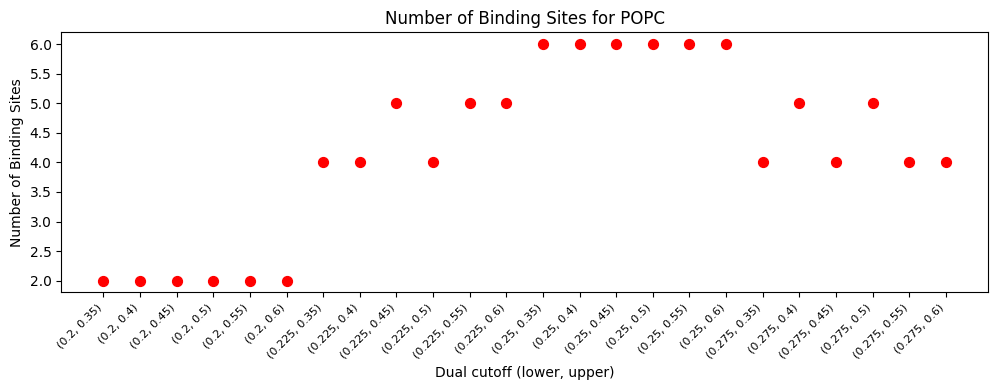

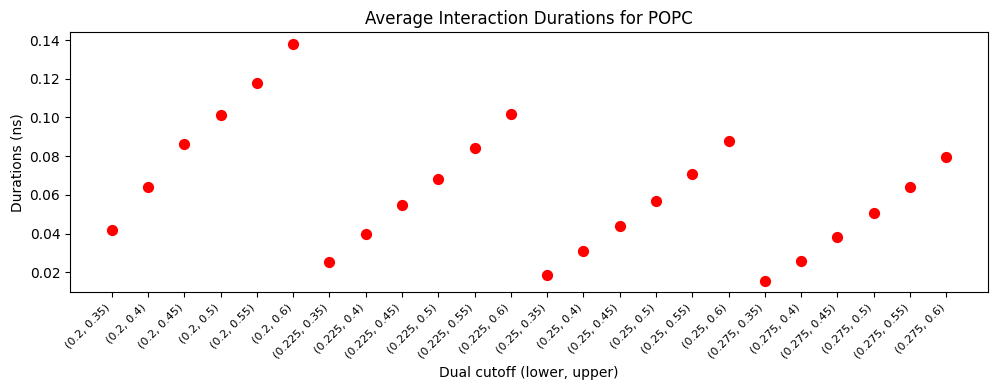

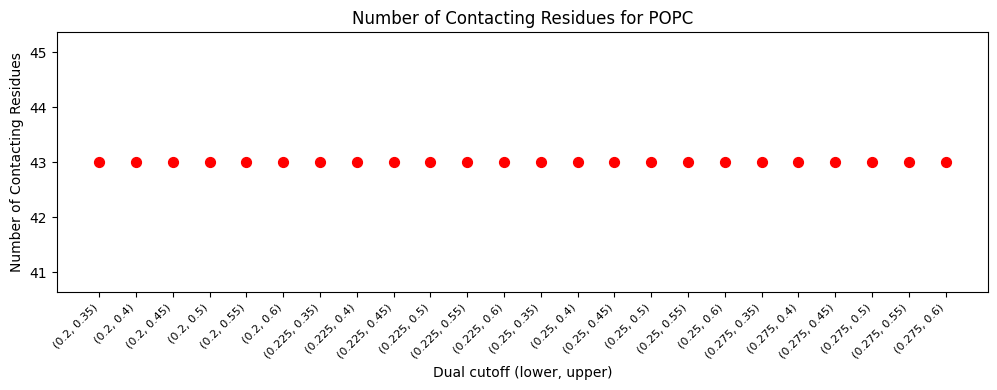

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Function to create scatter plots
def graph(cutoff_list, metric_values, ylabel, title, fn):
    fig, ax = plt.subplots(1, 1, figsize=(len(cutoff_list) * 0.42, 4))  # Adjust height for better visuals
    ax.scatter(np.arange(len(cutoff_list)), metric_values, s=50, color='red')
    ax.set_xticks(np.arange(len(cutoff_list)))
    ax.set_xticklabels(cutoff_list, rotation=45, ha='right', fontsize=8)  # Rotated labels for clarity
    ax.set_xlabel("Dual cutoff (lower, upper)")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.tight_layout()
    plt.savefig(fn, dpi=200)
    plt.show()

# Example: Number of Binding Sites
graph(
    cutoff_list=cutoff_list,
    metric_values=[num_of_binding_sites[cutoffs] for cutoffs in cutoff_list],
    ylabel="Number of Binding Sites",
    title=f"Number of Binding Sites for {lipid}",
    fn=f"{save_dir}/test_cutoff_num_of_bs_{lipid}.png"
)

# Example: Average Durations
graph(
    cutoff_list=cutoff_list,
    metric_values=[duration_avgs[cutoffs] for cutoffs in cutoff_list],
    ylabel=f"Durations ({timeunit})",
    title=f"Average Interaction Durations for {lipid}",
    fn=f"{save_dir}/test_cutoff_durations_{lipid}.png"
)

# Example: Number of Contacting Residues
graph(
    cutoff_list=cutoff_list,
    metric_values=[num_of_contacting_residues[cutoffs] for cutoffs in cutoff_list],
    ylabel="Number of Contacting Residues",
    title=f"Number of Contacting Residues for {lipid}",
    fn=f"{save_dir}/test_cutoff_num_of_contacting_residues_{lipid}.png"
)
